# 数据分析_kudeng(2-21-Y's)
本次我的数据分析总体思路分为如下四部分：
1. click整体分析
2. articles整体分析
3. 联合click与articles并按用户分组分析
4. 联合click与articles并按文章分组分析

## 1. 数据分析前的准备

In [10]:
# import packages
import random
from datetime import datetime
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [3]:
data_path = '../input/newsrs/'
save_path = './'

In [4]:
# user_click数据，用于click整体分析
train_click = pd.read_csv(data_path + 'train_click_log.csv')
test_click = pd.read_csv(data_path + 'testA_click_log.csv')

# articles数据，用于articles整体分析
articles = pd.read_csv(data_path + 'articles.csv')

# 建立click与articles联合数据
train_union = pd.merge(train_click.append(test_click), articles, how='left', left_on='click_article_id', right_on='article_id').drop(columns=['article_id'])
# test_union = pd.merge(test_click, articles, how='left', left_on='click_article_id', right_on='article_id').drop(columns=['article_id'])

# 对用户分组分析
user_based_click = train_union.groupby('user_id')
# user_based_click_test = test_union.groupby('user_id')

# 对文章分组分析
news_based_click = train_union.groupby('click_article_id')
# news_based_click_test = test_union.groupby('click_article_id')

## 2. click整体分析
得出结论（具体分析见下文）：
1. 训练集中共1,112,623条记录，其中有用户200,000个，新闻31,116篇
2. 测试集中用户均为新用户，故本次任务是对新用户进行新闻推荐（所以应该也可以考虑使用回归的方法预测）
1. 测试集中共518,010条记录，其中新用户50,000个，
1. 测试集中新闻16,330篇，未在训练集中出现的新闻4,264篇
3. click_timestamp列中有787条重复数据，进一步查看发现这些timestamp重复的787条数据与原数据完全无关，应该并不属于同一用户的重复操作，而是恰好有不同用户在同一时间点击了新闻，故不做删除

### 查看click训练集与测试集统计信息

In [67]:
train_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,199999,160417,1507029570190,4,1,17,1,13,1
1,199999,5408,1507029571478,4,1,17,1,13,1
2,199999,50823,1507029601478,4,1,17,1,13,1
3,199998,157770,1507029532200,4,1,17,1,25,5
4,199998,96613,1507029671831,4,1,17,1,25,5


In [68]:
train_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00


In [69]:
train_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112623 entries, 0 to 1112622
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
dtypes: int64(9)
memory usage: 76.4 MB


In [72]:
# 大致看一下各列的数据分布情况
for fea in train_click.columns:
    print(f'----------------{fea}----------------')
    print(train_click[fea].value_counts())

----------------user_id----------------
185083    241
143986    212
193264    180
179488    175
150481    175
         ... 
9752        2
11801       2
13850       2
15899       2
0           2
Name: user_id, Length: 200000, dtype: int64
----------------click_article_id----------------
234698    11886
123909    11438
336221    11290
96210     11146
183176    10487
          ...  
267968        1
286409        1
191006        1
227884        1
94760         1
Name: click_article_id, Length: 31116, dtype: int64
----------------click_timestamp----------------
1507320443928    3
1507984105656    3
1507038637829    2
1507760789162    2
1507576108699    2
                ..
1507996970335    1
1507248264512    1
1508176527783    1
1507294399811    1
1507393370287    1
Name: click_timestamp, Length: 1111836, dtype: int64
----------------click_environment----------------
4    1084627
2      25894
1       2102
Name: click_environment, dtype: int64
----------------click_deviceGroup---------------

In [ ]:
# 查看user数量 与 article数量
train_user_amount = data['user_id'].drop_duplicates().count()
print(f'user amount: {user_amount}')
article_amount = data['click_article_id'].drop_duplicates().count()
print(f'article amount: {article_amount}')
test_user_amount = test['user_id'].drop_duplicates().count()
print(f'test user amount: {test_user_amount}')

### 查看在测试集中出现但训练集中没有出现的用户  
注：这里发现理解错题意了，测试集中的用户都是从未出现在训练集中的，是给新用户推荐新闻

In [ ]:
test_users = test_click['user_id'].drop_duplicates()
train_users = train_click['user_id'].drop_duplicates()
print(f'test user amount:{test_users.count()}')
test_users.append(train_users).append(train_users).drop_duplicates(keep=False)
test_users

### 查看timestamp列有没有重复项（未完成）

In [1]:
train_click[train_click['click_timestamp'].duplicated()]['click_timestamp'].values

NameError: name 'train_click' is not defined

In [ ]:
train_click[train_click['click_timestamp']==1507048104349]

### 查看在测试集中出现 但未在训练集中出现的新闻

In [ ]:
news_from_train = train_click['click_article_id'].drop_duplicates()
print(f'total articles in train: {news_from_train.count()}')
news_from_test = test_click['click_article_id'].drop_duplicates()
print(f'total articles in test: {news_from_test.count()}')
news_only_in_test = news_from_test.append(news_from_train).append(news_from_train).drop_duplicates(keep=False)
news_only_in_test

### （未完成）对train和test各个列用核密度图或qq图对比其分布是否一致

## 3.Articles整体分析
结论：
1. 共有364,047篇文章，其中332,931篇未在训练集中出现过
2. 共有461个种类
3. 文章字数符合正态分布

In [74]:
articles.head()

,article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162


In [75]:
articles.describe()

,article_id,category_id,created_at_ts,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.000000
mean,182023.000000,283.108239,1.474070e+12,190.897727
std,105091.461061,136.723470,4.293038e+10,59.502766
min,0.000000,0.000000,1.159356e+12,0.000000
25%,91011.500000,199.000000,1.444925e+12,159.000000
50%,182023.000000,301.000000,1.489422e+12,186.000000
75%,273034.500000,399.000000,1.509891e+12,218.000000
max,364046.000000,460.000000,1.520943e+12,6690.000000


In [5]:
articles['category_id'].drop_duplicates().count()

461

In [19]:
articles['words_count'].describe()

count    364047.000000
mean        190.897727
std          59.502766
min           0.000000
25%         159.000000
50%         186.000000
75%         218.000000
max        6690.000000
Name: words_count, dtype: float64

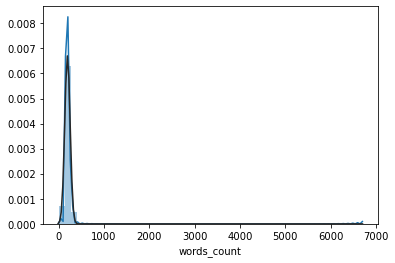

In [12]:
sns.distplot(articles['words_count'], fit=stats.norm)

((array([-4.62159517, -4.43415752, -4.33258172, ...,  4.33258172,
          4.43415752,  4.62159517]),
  array([   0,    0,    0, ..., 3507, 3808, 6690])),
 (52.28008717551541, 190.89772749123054, 0.8786056065163012))

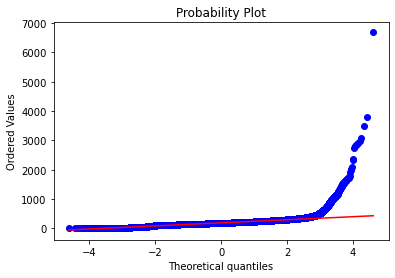

In [11]:
stats.probplot(articles['words_count'], plot=plt)

通过核密度图和Q-Q图，可以看出文章字数基本符合正态分布

In [79]:
all_news = articles['article_id'].drop_duplicates()
train_news = train_click['click_article_id'].drop_duplicates()
tmp = all_news.append(train_news).drop_duplicates(keep=False).count()
print(f'total articles: {all_news.count()}')
print(f'not found in train: {tmp}')

total articles: 364047
not found in train: 332931


## 4. 对用户分组进行联合分析
得出结论：
1. 绝大多数用户看的文章的字数在250字以下
2. 大多数用户点击的文章数在7篇及以下，少部分点击数量极多，可以考虑按点击量为用户定义活跃等级
3. 用户看的文章距离文章发出的时间中存在负数，需要预处理
4. 75%的分类的文章阅读次数在2200次以下，类别为281，375的分类极其受欢迎

count    250000.000000
mean          6.522532
std           8.866778
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         938.000000
Name: click_article_id, dtype: float64

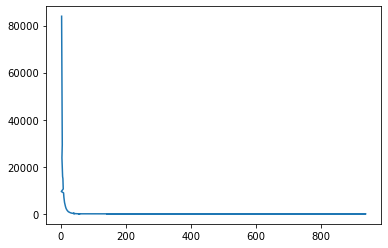

In [28]:
# 用户点击文章数
tmp = user_based_click['click_article_id'].count()
tmp.value_counts().plot()
tmp.describe()

In [13]:
# 每个用户看新闻的时间 与 该新闻发出的时间 的差的均值
train_union['time_after_created'] = train_union['click_timestamp']-train_union['created_at_ts']
after_created = sorted(train_union.groupby('user_id')['time_after_created'].mean())
after_created[:200]

[-953135091.0,
 -456237402.0,
 -322537987.0,
 -322213594.0,
 -299650268.0,
 -228621195.0,
 -212526446.4,
 -199271952.0,
 -192804123.0,
 -177808525.0,
 -165784509.0,
 -155268914.5,
 -145727482.33333334,
 -143619152.0,
 -141960481.0,
 -141694396.0,
 -139793044.0,
 -115312195.0,
 -106596413.0,
 -101958118.0,
 -101468925.0,
 -98245444.0,
 -97409187.66666667,
 -97223554.0,
 -97103964.0,
 -94630198.0,
 -94514277.0,
 -93779999.0,
 -91462339.5,
 -77323274.33333333,
 -75718208.33333333,
 -75625915.0,
 -74627838.0,
 -72183444.0,
 -68878840.66666667,
 -67680684.25,
 -63976327.0,
 -63890685.0,
 -62954048.0,
 -61204405.0,
 -60892364.0,
 -59588932.0,
 -59496445.0,
 -59309403.0,
 -58181544.666666664,
 -53060143.333333336,
 -52597223.0,
 -50585018.76923077,
 -45640824.0,
 -42344614.0,
 -41444251.0,
 -39777572.0,
 -38132024.0,
 -35061478.0,
 -34961958.0,
 -33477797.0,
 -33181359.0,
 -30952429.0,
 -30320762.0,
 -28556580.5,
 -28323154.0,
 -28205747.666666668,
 -26851702.0,
 -26634178.777777776,
 -265829

In [18]:
tmp = list(filter(lambda x: x>0, after_created))
pd.Series(tmp).describe()

count    2.498520e+05
mean     1.288215e+09
std      7.745079e+09
min      4.573750e+04
25%      2.703621e+07
50%      3.931965e+07
75%      6.175578e+07
max      2.270182e+11
dtype: float64

count    250000.000000
mean        205.830189
std          47.174030
min           8.000000
25%         187.500000
50%         202.000000
75%         217.750000
max        3434.500000
Name: words_count, dtype: float64

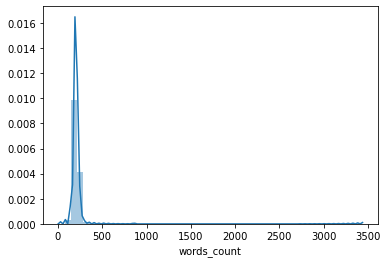

In [144]:
# 每个用户看的文章字数的均值
user_words = train_union.groupby('user_id')['words_count'].mean()
sns.distplot(user_words)
user_words.describe()

,category_id,user_id
count,297.000000,297.000000
mean,234.424242,5490.346801
std,134.451093,18107.333477
min,1.000000,1.000000
25%,123.000000,4.000000
50%,233.000000,76.000000
75%,353.000000,2196.000000
max,460.000000,179455.000000


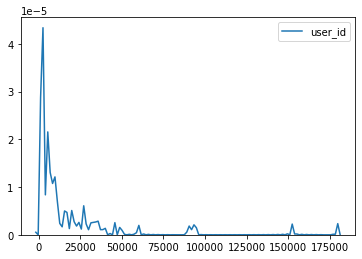

In [43]:
cat_popularity = train_union.groupby('category_id')['user_id'].count()
sns.kdeplot(cat_popularity)
cat_popularity = cat_popularity.reset_index().sort_values(by='user_id', ascending=False)
cat_popularity.describe()
# 结论：75%的分类的文章阅读次数在2200次以下，类别为281，375的分类极其受欢迎

In [171]:
cat_popularity['click_article_id']

179    179455
235    152587
156     94229
262     92587
280     90056
        ...  
59          1
143         1
56          1
174         1
58          1
Name: click_article_id, Length: 297, dtype: int64

## 5. 对文章分组进行联合分析
得出结论（待补充）：
1. 查看哪些文章在不同环境下被看过
2. 查看哪些文章在不同操作系统下被看过
3. 查看每篇文章最受欢迎的地区

In [48]:
train_union.head(1)

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id,created_at_ts,words_count,time_after_created
0,199999,160417,1507029570190,4,1,17,1,13,1,281,1506942089000,173,87481190


In [55]:
train_union.groupby('click_article_id')['click_environment']

0          4
1          4
2          4
3          4
4          4
          ..
1630525    4
1630526    4
1630531    4
1630540    4
1630578    4
Name: click_environment, Length: 86328, dtype: int64